# Characteristics and Near-Landfall Behavior of Philippine Tropical Cyclones (1979–2024)

This notebook supports the research paper:

**"Characteristics and Near-Landfall Behavior of Philippine Tropical Cyclones (1979–2024)"**  
by Bernard Alan B. Racoma and Gerry Bagtasa

---

## Description
 
This notebook processes and analyzes tropical cyclone (TC) data over the Philippines, with a focus on behavior within operational domains such as the PAR, TCID, TCAD, and the Philippine Coastal Waters (PCW). It calculates statistics such as TC lifetimes, intensity changes, and landfall characteristics, and visualizes these with geospatial plots.

---

## Overview

1. **Setup** – Import libraries and define file paths.  
2. **Preprocessing** – Load and clean IBTrACS and shapefile data.  
3. **Analysis** – Calculate lifetimes, intensity change, RI events, etc.  
4. **Geospatial Processing** – Perform spatial joins and intersections.  
5. **Visualization** – Plot tracks, maps, and other figures.  
6. **Summary Statistics** – Output descriptive stats for reporting.  
7. **Conclusion** – Summary of findings and links to paper results.





---
## Imports

In [1]:
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon, LineString
from shapely.prepared import prep
from shapely.ops import split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from tqdm.auto import tqdm


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


/home/cs-iesm-geostorm/WRF_Intel/miniconda3/envs/research/lib/python3.9/site-packages/pyproj/../../.././libtiff.so.5: version `LIBTIFF_4.6.1' not found (required by /home/cs-iesm-geostorm/WRF_Intel/miniconda3/lib/gdalplugins/../libgdal.so.36)
/home/cs-iesm-geostorm/WRF_Intel/miniconda3/envs/research/lib/python3.9/site-packages/pyproj/../../.././libtiff.so.5: version `LIBTIFF_4.6.1' not found (required by /home/cs-iesm-geostorm/WRF_Intel/miniconda3/lib/gdalplugins/../libgdal.so.36)
/home/cs-iesm-geostorm/WRF_Intel/miniconda3/envs/research/lib/python3.9/site-packages/pyproj/../../.././libtiff.so.5: version `LIBTIFF_4.6.1' not found (required by /home/cs-iesm-geostorm/WRF_Intel/miniconda3/lib/gdalplugins/../libgdal.so.36)
/home/cs-iesm-geostorm/WRF_Intel/miniconda3/envs/research/lib/python3.9/site-packages/pyproj/../../.././libtiff.so.5: version `LIBTIFF_4.6.1' not found (required by /home/cs-iesm-geostorm/WRF_Intel/miniconda3/lib/gdalplugins/../libgdal.so.36)


---
## Load data files

In [2]:
# Load the Philippine waters shapefile
gis_path = "/home/cs-iesm-geostorm/Data/gis/vector/"
phil_waters = gpd.read_file(os.path.join(gis_path,"boundaries/waters/philippine_waters_filled.shp"))
ph_shape = phil_waters.geometry.iloc[0]
phil_coast = gpd.read_file(os.path.join(gis_path,"boundaries/country/Country.shp"))

palawan_shape = gpd.read_file(os.path.join(gis_path,"boundaries/provincial/palawan.gpkg"))

In [3]:
# Load TCID, TCAD, and PAR polygons
gdf_tcid = gpd.read_file("PAGASA_TCID.gpkg").to_crs(4326)
gdf_tcad = gpd.read_file("PAGASA_TCAD.gpkg").to_crs(4326)
gdf_par = gpd.read_file("PAGASA_PAR.gpkg").to_crs(4326)


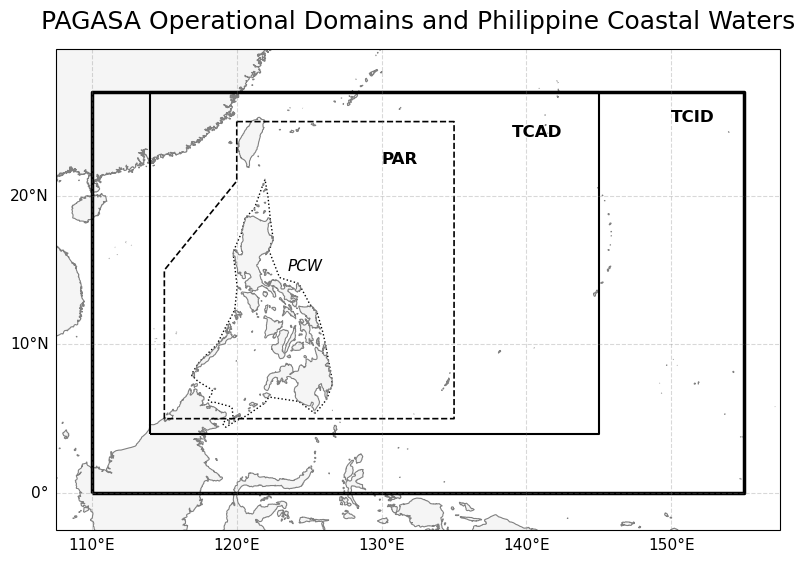

In [4]:
# Create plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add ocean and land
ax.add_feature(cfeature.LAND, facecolor='whitesmoke')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.coastlines(resolution='10m', color='gray', linewidth=0.8)

# Plot boundaries with consistent black outlines
gdf_tcid.boundary.plot(ax=ax, edgecolor='black', linewidth=2.5, linestyle='-')
gdf_tcad.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5, linestyle='-')
gdf_par.boundary.plot(ax=ax, edgecolor='black', linewidth=1.2, linestyle='--')

# Overlay Philippine Coastal Waters (PCW)
phil_waters.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.0, linestyle=':')
# ax.add_feature(cfeature.ShadedRelief(), alpha=0.5)
# ax.stock_img() 
# Add domain labels
ax.text(150, 25, "TCID", fontsize=12, fontweight='bold', color='black')
ax.text(139, 24, "TCAD", fontsize=12, fontweight='bold', color='black')
ax.text(130, 22.2, "PAR", fontsize=12, fontweight='bold', color='black')
ax.text(123.5, 15, "PCW", fontsize=11, style='italic', color='black')

# Set map extent
ax.set_extent([107.5, 157.5, -2.5, 27.5])

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.8, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(100, 175, 10))
gl.ylocator = mticker.FixedLocator(np.arange(0, 45, 10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 11, 'color': 'black'}
gl.ylabel_style = {'size': 11, 'color': 'black'}

# Title and save
ax.set_title("PAGASA Operational Domains and Philippine Coastal Waters", fontsize=18, pad=15)
plt.tight_layout()
plt.savefig("plot/Figure01_tc_domains_reference_map.png", dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# Load the IBTrACS data CSV
ibtracs = pd.read_csv(gis_path+"/ibtracs/ibtracs.WP.list.v04r01.csv", low_memory=False ,skiprows = [1])
# ibtracs = pd.read_csv(os.path.join(gis_path,"/ibtracs/ibtracs.WP.list.v04r01.csv"), low_memory=False ,skiprows = [1])
# ibtracs = ibtracs[ibtracs.SEASON>=1979]
ibtracs = ibtracs[(ibtracs.SEASON >= 1979) & (ibtracs.SEASON <= 2024)]
# Get unique storm IDs
unique_sids = ibtracs["SID"].unique()

In [6]:
len(unique_sids)

1507

In [7]:
# Convert to GeoDataFrame
gdf_tracks = gpd.GeoDataFrame(
    ibtracs,
    geometry=gpd.points_from_xy(ibtracs["LON"], ibtracs["LAT"]),
    crs="EPSG:4326"
)

---
## Calculate TC Intersections

In [8]:
from shapely.geometry import LineString
from shapely.prepared import prep

par_poly = gdf_par.geometry[0]
# Prepare the PH and PAR polygons
ph_prepared = prep(ph_shape)
par_prepared = prep(par_poly)

# Also get their bounding boxes for a fast first filter
ph_bounds = ph_shape.bounds
par_bounds = par_poly.bounds

intersect_results = []

for sid, group in tqdm(gdf_tracks.groupby("SID")):
    points = list(group.sort_values("ISO_TIME")["geometry"])
    if len(points) < 2:
        continue  # Skip storms with insufficient points

    track_line = LineString(points)
    line_bounds = track_line.bounds

    # Fast bounding box skip
    skip_ph = (line_bounds[2] < ph_bounds[0]) or (line_bounds[0] > ph_bounds[2]) or \
              (line_bounds[3] < ph_bounds[1]) or (line_bounds[1] > ph_bounds[3])

    skip_par = (line_bounds[2] < par_bounds[0]) or (line_bounds[0] > par_bounds[2]) or \
               (line_bounds[3] < par_bounds[1]) or (line_bounds[1] > par_bounds[3])

    # Use prepped geometry for faster intersects
    intersects_ph = False if skip_ph else ph_prepared.intersects(track_line)
    intersects_par = False if skip_par else par_prepared.intersects(track_line)

    intersect_results.append({
        "SID": sid,
        "intersects_ph": intersects_ph,
        "intersects_par": intersects_par
    })

# Wrap in DataFrame
df_intersects = pd.DataFrame(intersect_results)

# Final counts
n_track_in_ph = df_intersects["intersects_ph"].sum()
n_track_in_par = df_intersects["intersects_par"].sum()

print(f"{n_track_in_ph} TCs intersected PH.")
print(f"{n_track_in_par} TCs intersected PAR.")


  0%|          | 0/1507 [00:00<?, ?it/s]

437 TCs intersected PH.
961 TCs intersected PAR.


---
## Find TCs that originate OUTSIDE PCW

In [9]:

valid_sids = []
for sid, group in tqdm(gdf_tracks.groupby("SID")):
    group = group.sort_values("ISO_TIME")
    starts_outside = not ph_prepared.contains(group.iloc[0].geometry)
    ever_inside = group.geometry.apply(ph_prepared.contains).any()
    if starts_outside and ever_inside:
        valid_sids.append(sid)

# print(f"{len(valid_sids)} TCs enter from outside into PCW.")
# Find storms that start outside but enter PCW
origin_inside = gdf_tracks.groupby("SID").first()["geometry"].apply(ph_shape.contains)
sids_origin_outside = origin_inside[~origin_inside].index

# Final valid sids are those that both entered and originated outside
outside_origin_sids = list(set(valid_sids).intersection(set(sids_origin_outside)))
len(outside_origin_sids)

  0%|          | 0/1507 [00:00<?, ?it/s]

393

---
## Find points intersecting PCW shape

In [10]:
# Prep the PCW shape
# ph_prepared = prep(ph_shape)

# Store landfall points
landfall_records = []

# Filter to only TCs that intersected PCW (e.g., passed  new filtering)
gdf_tracks_lf = gdf_tracks[gdf_tracks["SID"].isin(outside_origin_sids)]

# Special case: SID 1983276N06130 intersects west edge of PCW
# We use a buffered version of the PCW polygon for this TC only
# to correct a visually verified edge-case landfall position.
ph_shape_buffered = ph_shape.buffer(0.2)  # or 0.1 degrees (~10–20 km)

# Toggle filter for westward moving TCs
filter_westward = True

valid_lf_sids = []
# Loop through storms
for sid, group in tqdm(gdf_tracks_lf.groupby("SID")):
    group = group.sort_values("ISO_TIME").reset_index(drop=True)
    points = list(group["geometry"])

    # Directional filter
    origin_lon = group.iloc[0].geometry.x
    origin_lon_cutoff = 120  # Adjust depending on your PCW bounds
    if origin_lon < origin_lon_cutoff:
        continue  # storm originated too far west

    # 1983276N06130 filter 
    this_ph_shape = ph_shape_buffered if sid == "1983276N06130" else ph_shape

    
    for i in range(len(points) - 1):
        p1, p2 = points[i], points[i + 1]
        segment = LineString([p1, p2])

        # Only proceed if segment intersects PCW
        if segment.intersects(this_ph_shape):
            intersection = segment.intersection(this_ph_shape)

            # If it's a Point or MultiPoint, store it
            if intersection.is_empty:
                continue
            elif intersection.geom_type == "Point":
                lf_point = intersection
            if intersection.geom_type == "MultiPoint":
                # Choose the point closest to p1 (entry point)
                lf_point = min(intersection.geoms, key=lambda pt: pt.distance(p1))
            elif intersection.geom_type == "LineString":
                # Use the start of the intersection line (likely entry point)
                lf_point = intersection.coords[0]  # or interpolate(0.0) if needed
                lf_point = Point(lf_point)

            else:
                continue  # skip unrecognized geometry types

            # Add metadata
            row = group.iloc[i + 1].copy()  # Take next point's time/metadata
            row["geometry"] = lf_point
            # Directional filtering
            if filter_westward:
                # dir_val = row.get("STORM_DIR")
                dir_val = pd.to_numeric(row.get("STORM_DIR"), errors='coerce')
                # pd.to_numeric(df_sid[dir_col], errors='coerce')
                if pd.isna(dir_val) or not (180 < dir_val < 360):
                    # Not westward
                    continue
            # Convert times to datetime
            lf_time = pd.to_datetime(row["ISO_TIME"])
            start_time = pd.to_datetime(group["ISO_TIME"].min())
            end_time = pd.to_datetime(group["ISO_TIME"].max())
            storm_duration = end_time - start_time

            # # Check if landfall is in the first 50% of lifetime
            # if lf_time - start_time > 0.5 * storm_duration:
            #     continue  # Skip late landfall
            
            landfall_records.append(row)
            break  # only keep FIRST landfall per storm

# # Create GeoDataFrame
# if landfall_records:
#     gdf_first_landfall_points = gpd.GeoDataFrame(landfall_records, geometry="geometry", crs=gdf_tracks.crs)
#     print(f"Found {len(gdf_first_landfall_points)} first landfall points.")
# else:
#     gdf_first_landfall_points = gpd.GeoDataFrame(columns=gdf_tracks.columns, geometry="geometry", crs=gdf_tracks.crs)
#     print("No first landfall points found.")

if landfall_records:
    gdf_first_landfall_points = gpd.GeoDataFrame(landfall_records, geometry="geometry", crs=gdf_tracks.crs)
    valid_lf_sids = gdf_first_landfall_points["SID"].unique().tolist()
    print(f"Found {len(valid_lf_sids)} valid landfalling TCs (with direction filtering).")
else:
    gdf_first_landfall_points = gpd.GeoDataFrame(columns=gdf_tracks.columns, geometry="geometry", crs=gdf_tracks.crs)
    valid_lf_sids = []
    print("No valid landfall points found.")



  0%|          | 0/393 [00:00<?, ?it/s]

Found 374 valid landfalling TCs (with direction filtering).


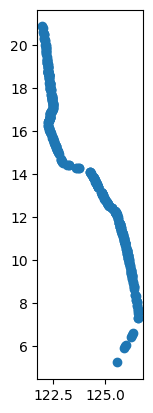

In [11]:
gdf_first_landfall_points.plot()
plt.show()

In [12]:
gdf_first_landfall_points.to_file("output/first_landfall_points.gpkg", layer="landfalls", driver="GPKG")


---
## Plot landfall points and histogram

In [13]:
gdf_landfall = gdf_first_landfall_points.copy()
gdf_landfall = gdf_landfall.dropna(subset=['LAT', 'LON'])  # just in case

In [14]:
# # ibtracs_lines = pd.read_csv("/home/cs-iesm-geostorm/Data/gis/vector/ibtracs/ibtracs.WP.list.v04r01.csv", low_memory=False ,skiprows = [1])
# ibtracs_lines_load = gpd.read_file("/home/cs-iesm-geostorm/Data/gis/vector/ibtracs/IBTrACS.WP.list.v04r01.lines.shp")
# ibtracs_lines = ibtracs_lines_load[ibtracs_lines_load.SID.isin(gdf_landfall.SID)].copy()

In [15]:
from shapely.geometry import LineString

# Store segments here
segment_records = []

# Loop through each storm (SID)
for sid, group in tqdm(gdf_tracks.groupby("SID")):
    group = group.sort_values("ISO_TIME").reset_index(drop=True)
    for i in range(len(group) - 1):
        p1 = group.loc[i, "geometry"]
        p2 = group.loc[i + 1, "geometry"]
        
        # Build LineString
        segment = LineString([p1, p2])
        
        # Store with metadata (optional)
        segment_records.append({
            "SID": sid,
            "start_time": group.loc[i, "ISO_TIME"],
            "end_time": group.loc[i + 1, "ISO_TIME"],
            "segment": segment
        })

# Create a GeoDataFrame
gdf_segments = gpd.GeoDataFrame(segment_records, geometry="segment", crs=gdf_tracks.crs)


  0%|          | 0/1507 [00:00<?, ?it/s]

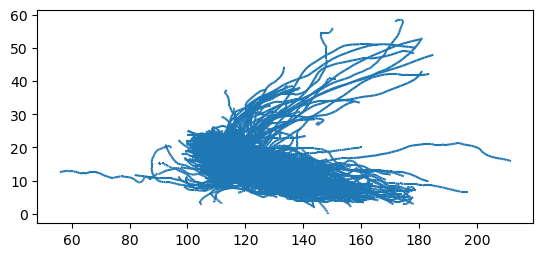

In [16]:
gdf_segments[gdf_segments.SID.isin(gdf_landfall.SID)].plot()
plt.show()

In [17]:
len(gdf_landfall.SID)

374

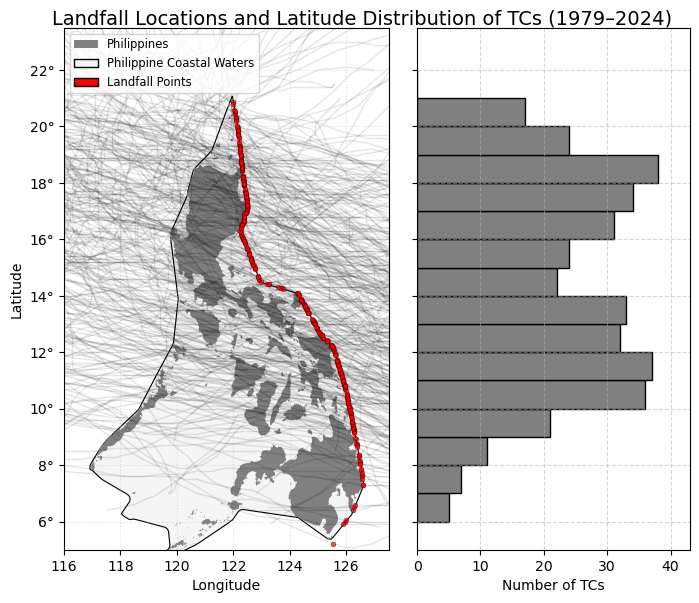

In [18]:
# Create figure with 2 subplots: Map and Histogram
fig, (ax_map, ax_hist) = plt.subplots(
    1, 2, figsize=(8, 6),
    gridspec_kw={'width_ratios': [2, 1]},
    sharey=True
)


latitudes = gdf_landfall['LAT'].values
bins = np.arange(6, 23)
counts, bin_edges = np.histogram(latitudes, bins=bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

lat_ticks = bin_edges[::2]  # This will use the histogram bins as y-ticks
lat_tick_labels = [f"{int(b)}°" for b in lat_ticks]


# ===== Left Panel: Map =====
phil_waters.plot(ax=ax_map, color='whitesmoke', edgecolor='black', linewidth=0.8)
phil_coast.plot(ax=ax_map, color='grey', edgecolor=None, linewidth=0.8)
gdf_landfall.plot(
    ax=ax_map, color='red', markersize=12, alpha=0.7,
    edgecolor='black', linewidth=0.3, label='Landfall Points', zorder=2
)

# Plot TC tracks as light gray lines
gdf_segments[gdf_segments.SID.isin(gdf_landfall.SID)].plot(
    ax=ax_map, color='k', linewidth=1.0, alpha=0.1, zorder=1
)

# Custom legend
legend_handles = [
    mpatches.Patch(facecolor='grey', edgecolor=None, label='Philippines'),
    mpatches.Patch(facecolor='whitesmoke', edgecolor='black', label='Philippine Coastal Waters'),
    mpatches.Patch(facecolor='red', edgecolor='black', label='Landfall Points')
]
ax_map.legend(handles=legend_handles, loc='upper left', fontsize='small', frameon=True)

# Map formatting

ax_map.set_xlabel("Longitude")
ax_map.set_ylabel("Latitude")
ax_map.set_aspect('equal', 'box')
ax_map.set_xlim([116, 127.5])
ax_map.set_ylim([5, 23.5])
# ax_map.set_title("Philippine Map with Coastal Waters", fontsize=12)
ax_map.grid(True, linestyle=':', alpha=0.4)

ax_map.set_yticks(lat_ticks)
ax_map.set_yticklabels(lat_tick_labels)

# # Optional horizontal reference lines
# for lat in range(6, 23):
#     ax_map.axhline(lat, color='gray', linestyle=':', linewidth=0.3, alpha=0.5)

# ===== Right Panel: Histogram =====

ax_hist.barh(bin_centers, counts, height=1, color='gray', edgecolor='black')
ax_hist.set_xlabel("Number of TCs")
# ax_hist.set_title("TC Landfall Distribution by Latitude", fontsize=12)
ax_hist.grid(True, linestyle='--', alpha=0.5)
ax_hist.set_xlim([0, max(counts) + 5])
ax_hist.set_ylabel("")  # Shared y-axis with map

# ===== Layout & Save =====
# plt.subplots_adjust(wspace=0.15) 
# plt.tight_layout(rect=[0, 0, 1, 0.98])
fig.subplots_adjust(left=0.06, right=0.98, bottom=0.08, top=0.95, wspace=-0.2)
fig.suptitle("Landfall Locations and Latitude Distribution of TCs (1979–2024)", 
             fontsize=14, y=0.98, x=0.57)

plt.savefig("plot/Figure02_lat_landfall_map_and_hist.png", dpi=300, bbox_inches='tight')
plt.show()

Test for bimodality

In [19]:
import numpy as np
from scipy.stats import skew, kurtosis

# Replace with your histogram counts
counts = np.array([5, 7, 11, 21, 36, 37, 32, 33, 22, 24, 31, 34, 38, 24, 17, 0])

# Calculate BC: bimodality coefficient
s = skew(counts)
k = kurtosis(counts, fisher=False)  # Pearson definition

n = len(counts)
BC = (s**2 + 1) / k

print(f"Bimodality Coefficient: {BC:.3f}")


Bimodality Coefficient: 0.630


In [20]:
len(valid_lf_sids)

374

---
## Now we label TCs according to domain

In [21]:
from shapely.geometry import LineString
from shapely.prepared import prep

domain_shapes = {
    "PCW": prep(ph_shape),
    "PAR": prep(gdf_par.unary_union),
    "TCAD": prep(gdf_tcad.unary_union),
    "TCID": prep(gdf_tcid.unary_union),
}

segment_counts = {
    "SID": [],
    "pcw_n_segments": [],
    "par_n_segments": [],
    "tcad_n_segments": [],
    "tcid_n_segments": []
}

for sid, group in tqdm(gdf_tracks.groupby("SID"), desc="Segment-based domain counts"):
    group = group.sort_values("ISO_TIME").reset_index(drop=True)
    segment_counts["SID"].append(sid)

    # Build segments
    segments = [
        LineString([group.at[i, "geometry"], group.at[i + 1, "geometry"]])
        for i in range(len(group) - 1)
    ]

    # Count segments that intersect each domain
    for key, domain in domain_shapes.items():
        count = sum(domain.intersects(seg) for seg in segments)
        segment_counts[f"{key.lower()}_n_segments"].append(count)


Segment-based domain counts:   0%|          | 0/1507 [00:00<?, ?it/s]

---
## Calculate TC lifetimes

In [22]:
df_segments = pd.DataFrame(segment_counts)

summary_data = []
regions = {
    "Philippine Coastal Waters (PCW)": "pcw_n_segments",
    "PAR": "par_n_segments",
    "TCAD": "tcad_n_segments",
    "TCID": "tcid_n_segments"
}

for region_name, count_col in regions.items():
    durations = df_segments[df_segments[count_col] > 0][count_col] * 3  # 3-hourly segment assumption

    summary_data.append({
        "Region": region_name,
        "N Storms": durations.count(),
        "Mean (hrs)": round(durations.mean(), 1),
        "Median (hrs)": round(durations.median(), 1),
        "Std Dev (hrs)": round(durations.std(), 1),
        "Min (hrs)": round(durations.min(), 1),
        "Max (hrs)": round(durations.max(), 1)
    })


In [23]:
# Ensure datetime
gdf_tracks["ISO_TIME"] = pd.to_datetime(gdf_tracks["ISO_TIME"])

# Group by SID and get start and end times
nwp_lifetimes = (
    gdf_tracks.groupby("SID")["ISO_TIME"]
    .agg(["min", "max"])
    .reset_index()
)

nwp_lifetimes["duration_hr"] = (
    nwp_lifetimes["max"] - nwp_lifetimes["min"]
).dt.total_seconds() / 3600

# Compute NWP summary
nwp_summary = {
    "Region": "NWP (Total lifetime)",
    "N Storms": len(nwp_lifetimes),
    "Mean (hrs)": round(nwp_lifetimes["duration_hr"].mean(), 1),
    "Median (hrs)": round(nwp_lifetimes["duration_hr"].median(), 1),
    "Std Dev (hrs)": round(nwp_lifetimes["duration_hr"].std(), 1),
    "Min (hrs)": round(nwp_lifetimes["duration_hr"].min(), 1),
    "Max (hrs)": round(nwp_lifetimes["duration_hr"].max(), 1)
}
summary_data.append(nwp_summary)

In [24]:
df_duration_summary = pd.DataFrame(summary_data)
df_duration_summary.to_csv("tc_duration_summary_by_domain_with_nwp.csv", index=False)
df_duration_summary


,Region,N Storms,Mean (hrs),Median (hrs),Std Dev (hrs),Min (hrs),Max (hrs)
0,Philippine Coastal Waters (PCW),437,23.4,21.0,16.1,3.0,117.0
1,PAR,961,86.9,84.0,52.5,3.0,429.0
2,TCAD,1231,120.4,117.0,71.2,3.0,474.0
3,TCID,1373,143.5,138.0,80.1,3.0,486.0
4,NWP (Total lifetime),1507,210.6,198.0,110.1,0.0,744.0


---
## Interpolate TC points, calculate acceleration and intensification

In [25]:
gdf_lf = gdf_tracks[gdf_tracks['SID'].isin(gdf_landfall.SID.unique())].copy()

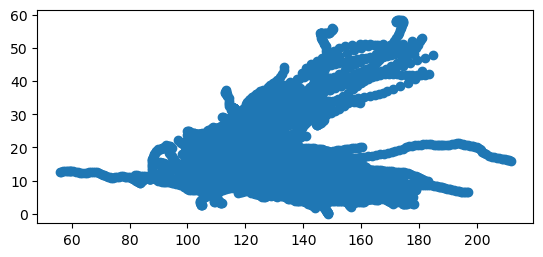

In [26]:
gdf_lf.plot()
plt.show()

In [27]:
def label_tc_by_segment_intersection(df_sid, ph_prepared, time_col='ISO_TIME'):
    df_sid = df_sid.sort_values(time_col).reset_index(drop=True)
    df_sid['phase'] = 'outside'
    df_sid['t_hours'] = np.nan

    entry_idx = None
    exit_idx = None

    # Generate segment lines and check for intersection
    for i in range(len(df_sid) - 1):
        p1 = df_sid.at[i, 'geometry']
        p2 = df_sid.at[i + 1, 'geometry']
        segment = LineString([p1, p2])

        if ph_prepared.intersects(segment):
            if entry_idx is None:
                entry_idx = i  # First intersecting segment
            exit_idx = i + 1  # Keep updating until last intersecting segment

    if entry_idx is None or exit_idx is None:
        return df_sid  # No intersection; skip labeling

    # Time reference point = first entry
    t_entry = df_sid.at[entry_idx, time_col]

    # Label phases and compute t_hours
    for i in range(len(df_sid)):
        current_time = df_sid.at[i, time_col]
        t_diff = (current_time - t_entry).total_seconds() / 3600

        if i < entry_idx:
            df_sid.at[i, 'phase'] = 'approach'
            df_sid.at[i, 't_hours'] = t_diff
        elif entry_idx <= i <= exit_idx:
            df_sid.at[i, 'phase'] = 'within'
            df_sid.at[i, 't_hours'] = t_diff
        elif i > exit_idx:
            df_sid.at[i, 'phase'] = 'departure'
            df_sid.at[i, 't_hours'] = t_diff

    return df_sid

def label_and_interpolate_tc(
    gdf_lf, 
    wind_col='WMO_WIND', 
    time_col='ISO_TIME', 
    dir_col='STORM_DIR',
    spd_col='STORM_SPEED',
    max_hours=48,
    filter_westward=True,
    verbose=False
):
    """
    Labels TC points as 'approach', 'within', or 'departure' and interpolates WMO_WIND.
    Optionally filters westward-moving TCs and handles string direction values.
    """
    processed = []

    # for sid in gdf_lf['SID'].unique():
    for sid in tqdm(gdf_lf['SID'].unique(), desc="Processing TCs"):

        df_sid = gdf_lf[gdf_lf['SID'] == sid].copy()
        df_sid = df_sid.sort_values(time_col).reset_index(drop=True)
        df_sid[time_col] = pd.to_datetime(df_sid[time_col]) 

        # Force numeric STORM_DIR (errors='coerce' sets invalid to NaN)
        df_sid[dir_col] = pd.to_numeric(df_sid[dir_col], errors='coerce')
        df_sid[spd_col] = pd.to_numeric(df_sid[spd_col], errors='coerce')

        # Compute STORM_ACCEL (change in speed from previous time step)
        speeds = df_sid[spd_col].to_numpy(dtype='float')  
        accel = speeds - np.roll(speeds, 1)
        accel[0] = np.nan  # first difference is undefined
        df_sid['STORM_ACCEL'] = accel

        
        # Optional: filter out non-westward TCs
        if filter_westward:
            valid_dirs = df_sid[dir_col].dropna()
            if valid_dirs.empty or not ((valid_dirs > 180) & (valid_dirs < 360)).any():
                if verbose:
                    print(f"Skipping SID {sid}: no valid westward direction")
                continue

        # After direction filtering, add this:
        start_point = df_sid.iloc[0].geometry
        if ph_prepared.contains(start_point):
            if verbose:
                print(f"Skipping SID {sid}: starts inside PCW")
            continue

        

        df_sid = label_tc_by_segment_intersection(df_sid, ph_prepared, time_col='ISO_TIME')

        
        # Interpolation
        in_window = df_sid['phase'].isin(['approach', 'within', 'departure'])
        df_sid['WMO_WIND_interp'] = np.nan

        # if df_sid.loc[in_window, wind_col].notna().sum() >= 2:
        #     df_sid.loc[in_window, 'WMO_WIND_interp'] = df_sid.loc[in_window, wind_col].interpolate(method='linear')

        # Clean and convert wind to float
        df_sid[wind_col] = pd.to_numeric(df_sid[wind_col], errors='coerce')
        
        # # Interpolate only if enough valid values
        # if df_sid.loc[in_window, wind_col].notna().sum() >= 2:
        #     df_sid.loc[in_window, 'WMO_WIND_interp'] = (
        #         df_sid.loc[in_window, wind_col]
        #         .interpolate(method='linear')
        #         .astype(float)  # Ensure it's float for assignment
        #     )

        # Interpolate only if enough valid values
        wind_series = df_sid.loc[in_window, wind_col]
        
        if wind_series.notna().sum() >= 2:
            interpolated = wind_series.interpolate(method='linear')
        
            # Mask out extrapolated values
            first_valid = wind_series.first_valid_index()
            last_valid = wind_series.last_valid_index()
        
            # interpolated.loc[:first_valid] = np.nan
            # interpolated.loc[last_valid+1:] = np.nan
        
            first_pos = wind_series.index.get_loc(first_valid)
            last_pos = wind_series.index.get_loc(last_valid)
            
            # Mask *before* first and *after* last (but not the valid points themselves)
            interpolated.iloc[:first_pos] = np.nan
            interpolated.iloc[last_pos+1:] = np.nan

            
            df_sid.loc[in_window, 'WMO_WIND_interp'] = interpolated.astype(float)

        
        processed.append(df_sid)

    df_out = pd.concat(processed, ignore_index=True)
    return df_out
df_ph_labeled = label_and_interpolate_tc(gdf_lf, filter_westward=True, verbose=True)


Processing TCs:   0%|          | 0/374 [00:00<?, ?it/s]

In [28]:
# Sort first to ensure order
df_ph_labeled = df_ph_labeled.sort_values(['SID', 't_hours']).copy()

# Initialize the new columns
df_ph_labeled['max_24h_intensification'] = np.nan
df_ph_labeled['delta_3hr'] = np.nan
df_ph_labeled['max_24h_acceleration'] = np.nan

# Loop through each storm
for sid, group in tqdm(df_ph_labeled.groupby('SID'), desc="Processing storms"):
    group = group.sort_values('t_hours').copy()
    intensification_list = []
    delta_3hr_list = []
    acceleration_list = []

    for i, current in group.iterrows():
        current_time = current['t_hours']
        current_wind = current['WMO_WIND_interp']
        # current_speed = current['STORM_SPEED']

        if np.isnan(current_wind):
            intensification_list.append(np.nan)
            delta_3hr_list.append(np.nan)
            # acceleration_list.append(np.nan) 
            continue

        # ================================
        # 1. Calculate the 24-hour max intensification
        past_window = group[(group['t_hours'] < current_time) & 
                            (group['t_hours'] >= current_time - 24)]
        
        max_increase = np.nan
        for _, past in past_window.iterrows():
            past_wind = past['WMO_WIND_interp']
            if not np.isnan(past_wind):
                delta = current_wind - past_wind
                if np.isnan(max_increase) or delta > max_increase:
                    max_increase = delta
        intensification_list.append(max_increase)
        
        # ================================
        # 2. Calculate the change in intensity (delta_3hr)
        past_window_3hr = group[(group['t_hours'] < current_time) & 
                                (group['t_hours'] >= current_time - 3)]

        if not past_window_3hr.empty:
            past_wind_3hr = past_window_3hr.iloc[-1]['WMO_WIND_interp']
            delta_3hr = current_wind - past_wind_3hr
        else:
            delta_3hr = np.nan

        delta_3hr_list.append(delta_3hr)

    for i, current in group.iterrows():
        # current_time = current['t_hours']
        # current_wind = current['WMO_WIND_interp']
        current_speed = current['STORM_SPEED']

        if np.isnan(current_speed):
            # intensification_list.append(np.nan)
            # delta_3hr_list.append(np.nan)
            acceleration_list.append(np.nan) 
            continue
        # ================================
        # 3. Max 24h Speed Change (NEW)
        speed_window = group[(group['t_hours'] < current_time) & 
                             (group['t_hours'] >= current_time - 24)]
        # speed_vals = speed_window['STORM_SPEED'].dropna().values
        max_increase_spd = np.nan
        for _, past in speed_window.iterrows():
            past_speed = past['STORM_SPEED']
            if not np.isnan(past_speed):
                delta = current_speed - past_speed
                if np.isnan(max_increase_spd) or delta > max_increase_spd:
                    max_increase_spd = delta
        acceleration_list.append(max_increase_spd)

        # if len(speed_vals) > 0:
        #     speed_change = np.max(speed_vals) - np.min(speed_vals)
        # else:
        #     speed_change = np.nan
        # acceleration_list.append(speed_change)

    # Assign the results back to the original df using group index
    df_ph_labeled.loc[group.index, 'max_24h_intensification'] = intensification_list
    df_ph_labeled.loc[group.index, 'delta_3hr'] = delta_3hr_list
    # print(sid, len(group.index), len(acceleration_list))

    df_ph_labeled.loc[group.index, 'max_24h_acceleration'] = acceleration_list  # NEW
# Output the updated DataFrame with both 'max_24h_intensification' and 'delta_3hr'
# df_ph_labeled.head()


Processing storms:   0%|          | 0/374 [00:00<?, ?it/s]

## Plot latitudinal dependence

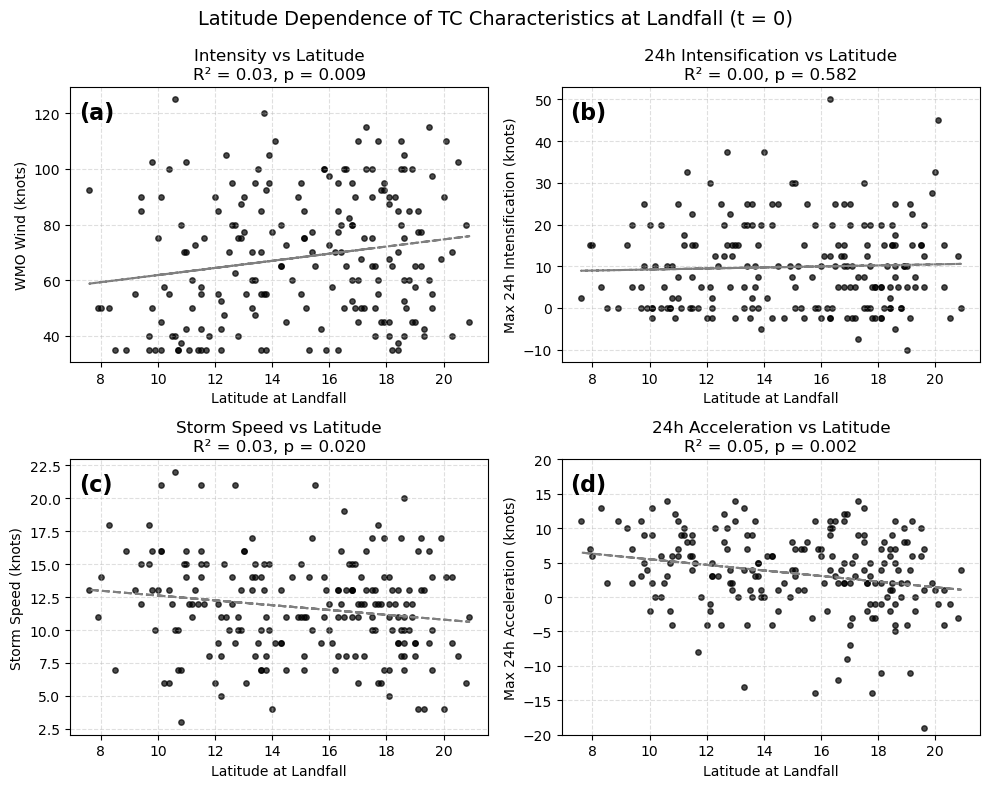

In [29]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Filter to landfall time (t = 0)
df_landfall = df_ph_labeled[df_ph_labeled['t_hours'] == 0].copy()

# Drop rows with missing data
df_landfall = df_landfall.dropna(subset=[
    'LAT', 'WMO_WIND_interp', 'max_24h_intensification', 'max_24h_acceleration', 'STORM_SPEED'
])

# Set up the 2x2 figure
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

# Define plot configs
plots = [
    ('WMO_WIND_interp', '(a) Intensity vs Latitude', 'WMO Wind (knots)'),
    ('max_24h_intensification', '(b) 24h Intensification vs Latitude', 'Max 24h Intensification (knots)'),
    ('STORM_SPEED', '(c) Storm Speed vs Latitude', 'Storm Speed (knots)'),
    ('max_24h_acceleration', '(d) 24h Acceleration vs Latitude', 'Max 24h Acceleration (knots)')
]

for i, (y_col, label, y_label) in enumerate(plots):
    ax = axs[i]
    x = df_landfall['LAT']
    y = df_landfall[y_col]

    # Scatter
    ax.scatter(x, y, color='black', s=15, alpha=0.7)

    # Regression
    slope, intercept, r_value, p_value, _ = linregress(x, y)
    reg_line = slope * x + intercept
    ax.plot(x, reg_line, color='gray', linestyle='--')

    # Plot title (keep this)
    ax.set_title(f"{label[4:]}\nR² = {r_value**2:.2f}, p = {p_value:.3f}")

    # In-plot label: (a), (b), etc.
    ax.text(0.02, 0.95, label[:3], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left')

    # Axes labels
    ax.set_xlabel("Latitude at Landfall")
    ax.set_ylabel(y_label)
    ax.grid(True, linestyle='--', alpha=0.4)

    # Only adjust ylim for panel (d)
    if i == 3:
        ax.set_ylim(-20, 20)
# Final layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Latitude Dependence of TC Characteristics at Landfall (t = 0)", fontsize=14)
plt.savefig("plot/lat_dependence_2x2_matplotlib.png", dpi=300, bbox_inches='tight')
plt.show()


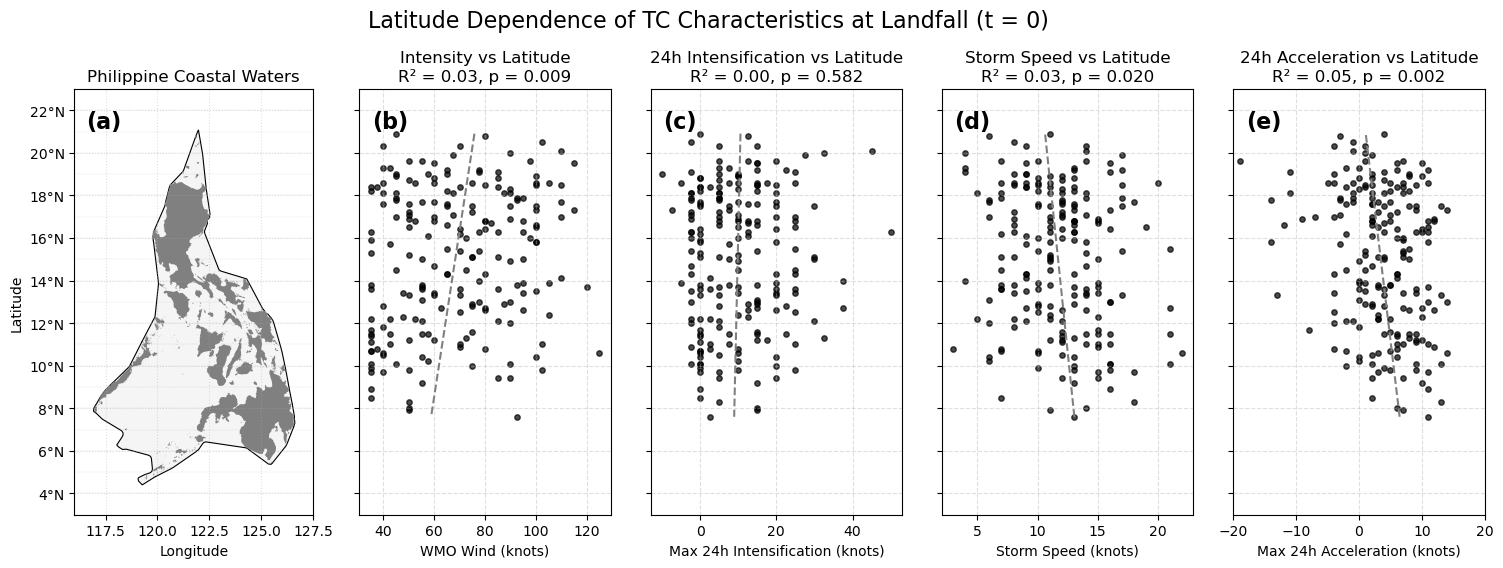

In [30]:
# import matplotlib.pyplot as plt
# from scipy.stats import linregress
# import matplotlib.patches as mpatches

# Create 1x5 figure
# fig, axs = plt.subplots(1, 5, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})
fig, axs = plt.subplots(
    1, 5, figsize=(16, 6),
    gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]},
    sharey=True 
)


ax_map, ax1, ax2, ax3, ax4 = axs

df_landfall = df_ph_labeled[df_ph_labeled['t_hours'] == 0].copy()

# Drop rows with missing data
df_landfall = df_landfall.dropna(subset=[
    'LAT', 'WMO_WIND_interp', 'max_24h_intensification', 'max_24h_acceleration', 'STORM_SPEED'
])

# ===== Panel 1: Map =====
phil_waters.plot(ax=ax_map, color='whitesmoke', edgecolor='black', linewidth=0.8)
phil_coast.plot(ax=ax_map, color='grey', edgecolor=None, linewidth=0.8)
ax_map.set_xlim([116, 127.5])
ax_map.set_ylim([3, 23])
plt.draw()
# Now set ticks after drawing
lat_ticks = np.arange(4, 24, 2)
ax_map.set_yticks(lat_ticks)
ax_map.set_yticklabels([f"{lat}°N" for lat in lat_ticks])
# print(ax_map.get_yticks())
ax_map.set_xlabel("Longitude")
ax_map.set_ylabel("Latitude")
ax_map.set_title(f"\nPhilippine Coastal Waters")
ax_map.grid(True, linestyle=':', alpha=0.4)
for lat in range(4, 23):
    ax_map.axhline(lat, color='gray', linestyle=':', linewidth=0.3, alpha=0.5)
ax_map.text(0.05, 0.95, "(a)", transform=ax_map.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left')

# ===== Panels 2-5: Latitude vs Characteristics (Vertical plots)

# plots = [
#     ('WMO_WIND_interp', '(b)', 'WMO Wind (knots)'),
#     ('max_24h_intensification', '(c)', 'Max 24h Intensification (kt)'),
#     ('STORM_SPEED', '(d)', 'Storm Speed (kt)'),
#     ('max_24h_acceleration', '(e)', 'Max 24h Acceleration (kt)')
# ]

plots = [
    ('WMO_WIND_interp', '(b) Intensity vs Latitude', 'WMO Wind (knots)'),
    ('max_24h_intensification', '(c) 24h Intensification vs Latitude', 'Max 24h Intensification (knots)'),
    ('STORM_SPEED', '(d) Storm Speed vs Latitude', 'Storm Speed (knots)'),
    ('max_24h_acceleration', '(e) 24h Acceleration vs Latitude', 'Max 24h Acceleration (knots)')
]

axes = [ax1, ax2, ax3, ax4]


for ax, (y_col, label, xlabel) in zip(axes, plots):
    x = df_landfall['LAT']
    y = df_landfall[y_col]
    

    ax.scatter(y, x, color='black', s=15, alpha=0.7)
    
    # Regress x = LAT against y
    slope, intercept, r_value, p_value, _ = linregress(x, y)
    # x_vals = np.linspace(x.min(), x.max(), 100)
    # y_fit = slope * x_vals + intercept
    y_fit = slope * x + intercept
    # Scatter: plot y vs x, but flipped (characteristic on x, lat on y)

    
    # Plot the regression line using characteristic (x) vs lat (y)
    # ax.plot(y_fit, x, color='gray', linestyle='dashed')
    # ax.plot([y_fit.values[0],y_fit.values[-1]], [x.values[0], x.values[-1]], color='gray', linestyle='dashed')
    # Quick fix to get dashed lines
    if label[:3] == '(d)' or label[:3] == '(e)':
        ax.plot([y_fit.values.max(),y_fit.values.min()], [x.values.min(), x.values.max()], color='gray', linestyle='dashed')
    if label[:3] == '(b)' or label[:3] == '(c)':
        ax.plot([y_fit.values.max(),y_fit.values.min()], [x.values.max(), x.values.min()], color='gray', linestyle='dashed')


    # Labels and layout
    ax.set_xlabel(xlabel)
    # if ax != ax_map:
    #     ax.set_yticks([])

    
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.text(0.05, 0.95, f"{label[:3]}", transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left')
    # ax.set_title(f"R² = {r_value**2:.2f}, p = {p_value:.3f}", fontsize=14)
    ax.set_title(f"{label[4:]}\nR² = {r_value**2:.2f}, p = {p_value:.3f}")
    if label[:3] == '(e)':
        ax.set_xlim([-20, 20])

# Final layout
# fig.suptitle("Latitude Dependence of Landfalling TC Characteristics and Location (1979–2024)", fontsize=16, y=0.94)
plt.suptitle("Latitude Dependence of TC Characteristics at Landfall (t = 0)", fontsize=16, y=0.94)
plt.tight_layout(rect=[0.05, 0, 1, 0.96])  # Leave more space on the left

plt.savefig("plot/Figure03_lat_dependence_5panel_vertical.png", dpi=300, bbox_inches='tight')
plt.show()


In [31]:

# data = {
#     't_hours': [0]*100,
#     'STORM_SPEED': [10 + i%5 + (i%3 - 1) * 2 for i in range(100)],  # Rough variability
#     'max_24h_acceleration': [(-1)**(i%3) * (i % 10) for i in range(100)]
# }

# df_ph_labeled = pd.DataFrame(data)

# Filter to t = 0 and drop NA
df_landfall = df_ph_labeled[df_ph_labeled['t_hours'] == 0].copy()
df_landfall = df_landfall.dropna(subset=['STORM_SPEED', 'max_24h_acceleration'])

# Basic stats
avg_speed = df_landfall['STORM_SPEED'].mean()
std_speed = df_landfall['STORM_SPEED'].std()

avg_accel = df_landfall['max_24h_acceleration'].mean()
std_accel = df_landfall['max_24h_acceleration'].std()

# Correlation between storm speed and acceleration at t = 0
correlation = df_landfall[['STORM_SPEED', 'max_24h_acceleration']].corr().iloc[0, 1]

{
    "Average Storm Speed (knots)": round(avg_speed, 2),
    "Speed Std Dev (knots)": round(std_speed, 2),
    "Average Max 24h Acceleration (knots)": round(avg_accel, 2),
    "Acceleration Std Dev (knots)": round(std_accel, 2),
    "Speed-Acceleration Correlation": round(correlation, 2)
}


{'Average Storm Speed (knots)': 12.43,
 'Speed Std Dev (knots)': 4.29,
 'Average Max 24h Acceleration (knots)': 4.53,
 'Acceleration Std Dev (knots)': 6.21,
 'Speed-Acceleration Correlation': 0.62}

## Calculate and plot TC evolution

## Update: include time evolution for non-RI TCs

In [32]:

def safe_percentile(x, q):
    x_clean = x.dropna()
    return np.percentile(x_clean, q) if len(x_clean) > 0 else np.nan

# Prep main DF
df_plot = df_ph_labeled.copy()
df_plot = df_plot[df_plot['t_hours'].notna()]
df_plot['t_step'] = df_plot['t_hours'].round()
df_plot = df_plot[df_plot['t_step'].between(-72, 72)]

#Group and compute stats for all TCs 
grouped = df_plot.groupby('t_step')

stats = grouped.agg(
    median=('WMO_WIND_interp', 'median'),
    p25=('WMO_WIND_interp', lambda x: safe_percentile(x, 25)),
    p75=('WMO_WIND_interp', lambda x: safe_percentile(x, 75)),
    count=('WMO_WIND_interp', 'count'),
    median_max_intens=('max_24h_intensification', 'median'),
    p25_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 25)),
    p75_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 75)),
    median_delta_3hr=('delta_3hr', 'median'),
    p25_delta_3hr=('delta_3hr', lambda x: safe_percentile(x, 25)),
    p75_delta_3hr=('delta_3hr', lambda x: safe_percentile(x, 75)),
    median_speed=('STORM_SPEED', 'median'),
    p25_speed=('STORM_SPEED', lambda x: safe_percentile(x, 25)),
    p75_speed=('STORM_SPEED', lambda x: safe_percentile(x, 75)),
    median_accel=('STORM_ACCEL', 'median'),
    p25_accel=('STORM_ACCEL', lambda x: safe_percentile(x, 25)),
    p75_accel=('STORM_ACCEL', lambda x: safe_percentile(x, 75)),
    median_max_accel=('max_24h_acceleration', 'median'),
    p25_max_accel=('max_24h_acceleration', lambda x: safe_percentile(x, 25)),
    p75_max_accel=('max_24h_acceleration', lambda x: safe_percentile(x, 75)),
).reset_index()

stats = stats[stats['count'] >= 5]

# --- RI storm tagging ---
ri_criteria = (
    # (df_ph_labeled['t_hours'] >= -72) &
    # (df_ph_labeled['t_hours'] <= 72) &
    (df_ph_labeled['t_hours'] >= -24) &
    (df_ph_labeled['t_hours'] <= 0) &
    (df_ph_labeled['max_24h_intensification'] >= 30)
)
ri_sids = df_ph_labeled.loc[ri_criteria, 'SID'].unique()
df_ph_labeled['is_RI'] = df_ph_labeled['SID'].isin(ri_sids)

# Prep RI subset
df_ri = df_ph_labeled[df_ph_labeled['is_RI']].copy()
df_ri = df_ri[df_ri['t_hours'].notna()]
df_ri['t_step'] = df_ri['t_hours'].round()
df_ri = df_ri[df_ri['t_step'].between(-72, 72)]

# --- Group and compute stats for RI TCs ---
grouped_ri = df_ri.groupby('t_step')

stats_ri = grouped_ri.agg(
    median=('WMO_WIND_interp', 'median'),
    p25=('WMO_WIND_interp', lambda x: safe_percentile(x, 25)),
    p75=('WMO_WIND_interp', lambda x: safe_percentile(x, 75)),
    count=('WMO_WIND_interp', 'count'),
    median_max_intens=('max_24h_intensification', 'median'),
    p25_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 25)),
    p75_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 75)),
    median_delta_3hr=('delta_3hr', 'median'),
    p25_delta_3hr=('delta_3hr', lambda x: safe_percentile(x, 25)),
    p75_delta_3hr=('delta_3hr', lambda x: safe_percentile(x, 75)),
    median_speed=('STORM_SPEED', 'median'),
    p25_speed=('STORM_SPEED', lambda x: safe_percentile(x, 25)),
    p75_speed=('STORM_SPEED', lambda x: safe_percentile(x, 75)),
    median_accel=('STORM_ACCEL', 'median'),
    p25_accel=('STORM_ACCEL', lambda x: safe_percentile(x, 25)),
    p75_accel=('STORM_ACCEL', lambda x: safe_percentile(x, 75)),
    median_max_accel=('max_24h_acceleration', 'median'),
    p25_max_accel=('max_24h_acceleration', lambda x: safe_percentile(x, 25)),
    p75_max_accel=('max_24h_acceleration', lambda x: safe_percentile(x, 75)),
).reset_index()

stats_ri = stats_ri[stats_ri['count'] >= 5]

# Identify non-RI storms
nonri_sids = df_ph_labeled.loc[~df_ph_labeled['SID'].isin(ri_sids), 'SID'].unique()
df_nonri = df_ph_labeled[df_ph_labeled['SID'].isin(nonri_sids)].copy()
df_nonri = df_nonri[df_nonri['t_hours'].notna()]
df_nonri['t_step'] = df_nonri['t_hours'].round()
df_nonri = df_nonri[df_nonri['t_step'].between(-72, 72)]

# Group and compute stats for non-RI TCs
grouped_nonri = df_nonri.groupby('t_step')
stats_nonri = grouped_nonri.agg(
    median=('WMO_WIND_interp', 'median'),
    p25=('WMO_WIND_interp', lambda x: safe_percentile(x, 25)),
    p75=('WMO_WIND_interp', lambda x: safe_percentile(x, 75)),
    count=('WMO_WIND_interp', 'count'),
    median_max_intens=('max_24h_intensification', 'median'),
    p25_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 25)),
    p75_max_intens=('max_24h_intensification', lambda x: safe_percentile(x, 75)),
    median_delta_3hr=('delta_3hr', 'median'),
    p25_delta_3hr=('delta_3hr', lambda x: safe_percentile(x, 25)),
    p75_delta_3hr=('delta_3hr', lambda x: safe_percentile(x, 75)),
    median_speed=('STORM_SPEED', 'median'),
    p25_speed=('STORM_SPEED', lambda x: safe_percentile(x, 25)),
    p75_speed=('STORM_SPEED', lambda x: safe_percentile(x, 75)),
    median_accel=('STORM_ACCEL', 'median'),
    p25_accel=('STORM_ACCEL', lambda x: safe_percentile(x, 25)),
    p75_accel=('STORM_ACCEL', lambda x: safe_percentile(x, 75)),
    median_max_accel=('max_24h_acceleration', 'median'),
    p25_max_accel=('max_24h_acceleration', lambda x: safe_percentile(x, 25)),
    p75_max_accel=('max_24h_acceleration', lambda x: safe_percentile(x, 75)),
).reset_index()

stats_nonri = stats_nonri[stats_nonri['count'] >= 5]


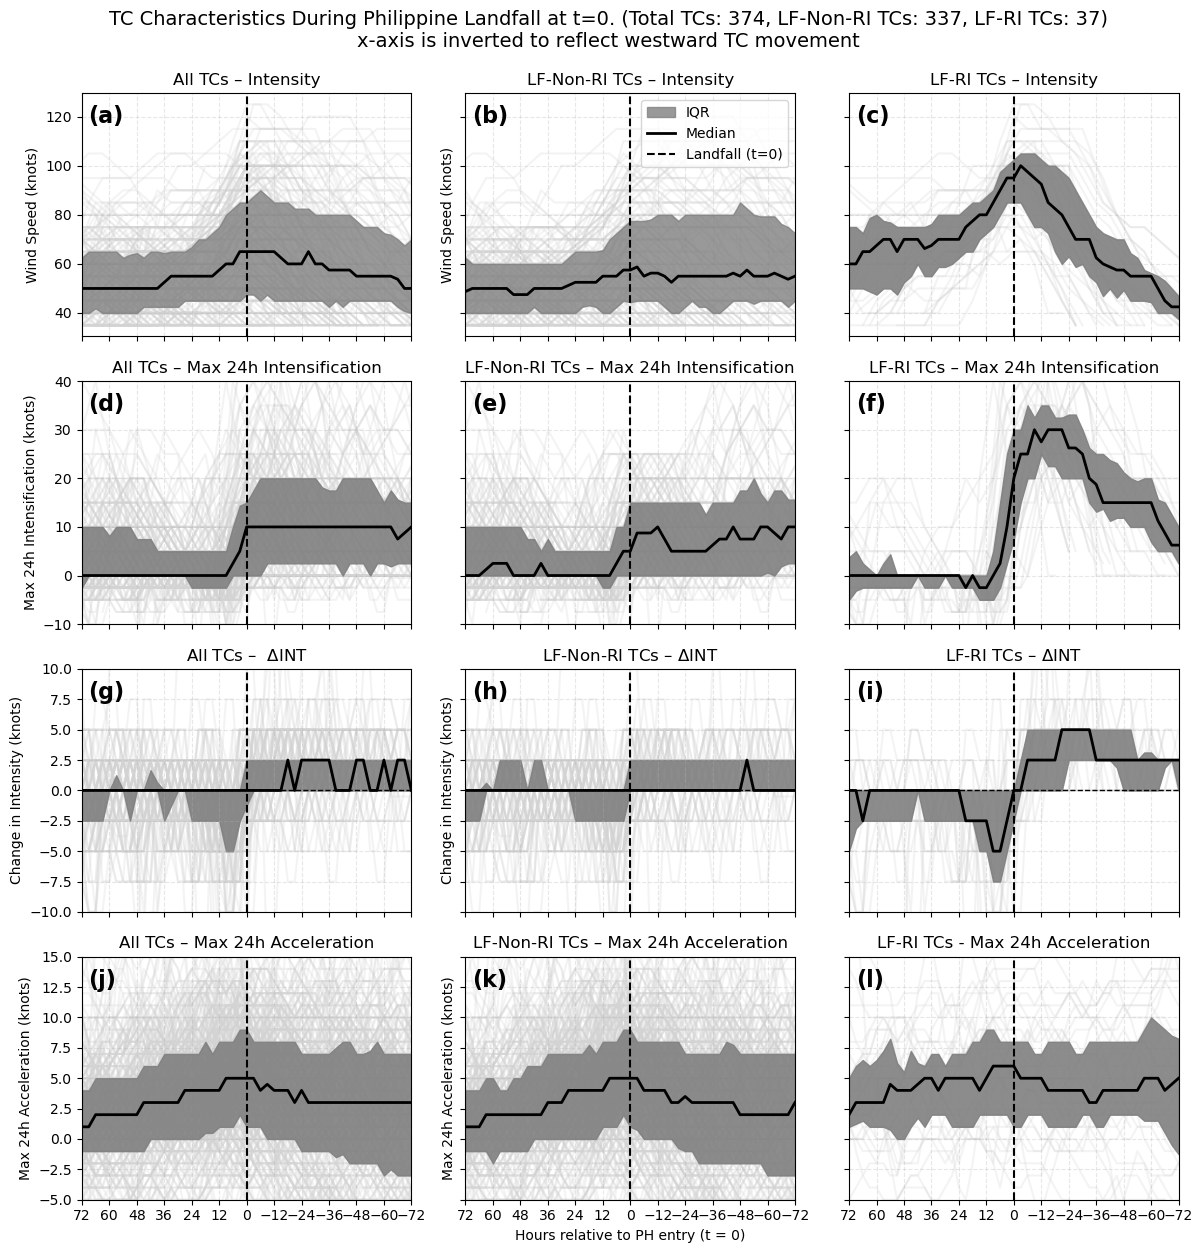

In [37]:


# Create the figure with 4 rows and 2 columns
fig, axs = plt.subplots(4, 3, figsize=(12, 12), sharex=True, sharey='row')
# Define labels for subplot panels
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']
for ax, label in zip(axs.flat, panel_labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes, fontsize=16,
            fontweight='bold', va='top', ha='left')


# ==== Top Left: All TCs - Intensity ====
ax_wind = axs[0, 0]
for sid, group in df_plot.groupby('SID'):
    ax_wind.plot(group['t_step'], group['WMO_WIND_interp'], color='lightgray', alpha=0.25, zorder=1)

ax_wind.fill_between(stats['t_step'], stats['p25'], stats['p75'], color='grey', alpha=0.8, label='IQR', zorder=2)
ax_wind.plot(stats['t_step'], stats['median'], color='black', linewidth=2, label='Median', zorder=3)
ax_wind.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')
ax_wind.set_title("All TCs – Intensity")
ax_wind.set_ylabel("Wind Speed (knots)")
ax_wind.grid(True, linestyle='--', alpha=0.3)
# ax1.legend(loc='upper left')
# # Secondary axis for storm count
# ax2 = ax1.twinx()
# ax2.plot(stats['t_step'], stats['count'], color='orange', linestyle='--', alpha=0.6, label='Storm count')
# ax2.set_ylabel("Storm count", color='orange')
# ax2.tick_params(axis='y', labelcolor='orange')
# ax2.legend(loc='upper right')

# ==== Top Middle: Non-RI TCs - Intensity ====
ax_wind_nonri = axs[0, 1]
for sid, group in df_nonri.groupby('SID'):
    ax_wind_nonri.plot(group['t_step'], group['WMO_WIND_interp'], color='lightgray', alpha=0.25, zorder=1)

ax_wind_nonri.fill_between(stats_nonri['t_step'], stats_nonri['p25'], stats_nonri['p75'], color='grey', alpha=0.8, label='IQR', zorder=2)
ax_wind_nonri.plot(stats_nonri['t_step'], stats_nonri['median'], color='black', linewidth=2, label='Median', zorder=3)
ax_wind_nonri.axvline(0, color='black', linestyle='--', label='Landfall (t=0)')
ax_wind_nonri.set_title("LF-Non-RI TCs – Intensity")
ax_wind_nonri.set_ylabel("Wind Speed (knots)")
ax_wind_nonri.grid(True, linestyle='--', alpha=0.3)
ax_wind_nonri.legend(loc='upper right')

# ==== Top Right: RI TCs - Intensity ====
ax_wind_ri = axs[0, 2]
for sid, group in df_ri.groupby('SID'):
    ax_wind_ri.plot(group['t_step'], group['WMO_WIND_interp'], color='lightgray', alpha=0.25, zorder=1)

ax_wind_ri.fill_between(stats_ri['t_step'], stats_ri['p25'], stats_ri['p75'], color='grey', alpha=0.9, label='IQR', zorder=2)
ax_wind_ri.plot(stats_ri['t_step'], stats_ri['median'], color='black', linewidth=2, label='Median', zorder=3)
ax_wind_ri.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')
ax_wind_ri.set_title("LF-RI TCs – Intensity")
ax_wind_ri.grid(True, linestyle='--', alpha=0.3)
# ax_wind_ri.legend(loc='upper right')

# ax4 = ax3.twinx()
# ax4.plot(stats_ri['t_step'], stats_ri['count'], color='orange', linestyle='--', alpha=0.6, label='Storm count')
# ax4.set_ylabel("Storm count", color='orange')
# ax4.tick_params(axis='y', labelcolor='orange')
# ax4.legend(loc='upper right')

# ==== Row 2 Left: All TCs - Intensification ====
ax_int = axs[1, 0]
for sid, group in df_plot.groupby('SID'):
    ax_int.plot(group['t_step'], group['max_24h_intensification'], color='lightgray', alpha=0.25, zorder=1)

ax_int.fill_between(stats['t_step'], stats['p25_max_intens'], stats['p75_max_intens'],
                 color='grey', alpha=0.9, label='IQR', zorder=2)
ax_int.plot(stats['t_step'], stats['median_max_intens'], color='black', linewidth=2, label='Median', zorder=3)
ax_int.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')
# ax5.set_xlabel("Hours relative to PH entry (t = 0)")
ax_int.set_ylabel("Max 24h Intensification (knots)")
ax_int.set_title("All TCs – Max 24h Intensification")
ax_int.grid(True, linestyle='--', alpha=0.3)
ax_int.set_ylim([-10,40])
# ax5.legend(loc='upper left')


# ==== Row 2 Middle: Non-RI TCs - Intensification ====
ax_int_nonri = axs[1, 1]
for sid, group in df_nonri.groupby('SID'):
    ax_int_nonri.plot(group['t_step'], group['max_24h_intensification'], color='lightgray', alpha=0.25, zorder=1)

ax_int_nonri.fill_between(stats_nonri['t_step'], stats_nonri['p25_max_intens'], stats_nonri['p75_max_intens'],
                 color='grey', alpha=0.9, label='IQR', zorder=2)
ax_int_nonri.plot(stats_nonri['t_step'], stats_nonri['median_max_intens'], color='black', linewidth=2, label='Median', zorder=3)
ax_int_nonri.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')
# ax6.set_xlabel("Hours relative to PH entry (t = 0)")
ax_int_nonri.set_title("LF-Non-RI TCs – Max 24h Intensification")
ax_int_nonri.grid(True, linestyle='--', alpha=0.3)
# ax6.legend(loc='upper left')

# ==== Row 2 Right: RI TCs - Intensification ====
ax_int_ri = axs[1, 2]
for sid, group in df_ri.groupby('SID'):
    ax_int_ri.plot(group['t_step'], group['max_24h_intensification'], color='lightgray', alpha=0.25, zorder=1)

ax_int_ri.fill_between(stats_ri['t_step'], stats_ri['p25_max_intens'], stats_ri['p75_max_intens'],
                 color='grey', alpha=0.9, label='IQR', zorder=2)
ax_int_ri.plot(stats_ri['t_step'], stats_ri['median_max_intens'], color='black', linewidth=2, label='Median', zorder=3)
ax_int_ri.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')
# ax_int_ri.set_xlabel("Hours relative to PH entry (t = 0)")
ax_int_ri.set_title("LF-RI TCs – Max 24h Intensification")
ax_int_ri.grid(True, linestyle='--', alpha=0.3)
# ax_int_ri.legend(loc='upper left')

# ==== Third Row Left: All TCs and RI TCs - Delta 3hr ====
# Left: All TCs - Delta 3hr
ax_del = axs[2, 0]
for sid, group in df_plot.groupby('SID'):
    ax_del.plot(group['t_step'], group['delta_3hr'], color='lightgray', alpha=0.25, zorder=1)

ax_del.fill_between(stats['t_step'], stats['p25_delta_3hr'], stats['p75_delta_3hr'],
                 color='grey', alpha=0.9, label='IQR', zorder=1)
ax_del.plot(stats['t_step'], stats['median_delta_3hr'], color='black', linewidth=2, label='Median', zorder=3)
ax_del.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')

# Add a horizontal line at y=0 for delta_3hr
ax_del.axhline(0, color='black', linestyle='--', linewidth=1)

# ax_del.set_xlabel("Hours relative to PH entry (t = 0)")
ax_del.set_ylabel("Change in Intensity (knots)")
ax_del.set_title("All TCs –  $\Delta$INT")
ax_del.grid(True, linestyle='--', alpha=0.3)
# ax_del.legend(loc='upper left')
ax_del.set_ylim([-10,10])

# ==== Third Row Middle: Non-RI TCs - Delta 3hr ====
# Left: All TCs - Delta 3hr
ax_del_nonri = axs[2, 1]
for sid, group in df_nonri.groupby('SID'):
    ax_del_nonri.plot(group['t_step'], group['delta_3hr'], color='lightgray', alpha=0.25, zorder=1)

ax_del_nonri.fill_between(stats_nonri['t_step'], stats_nonri['p25_delta_3hr'], stats_nonri['p75_delta_3hr'],
                 color='grey', alpha=0.9, label='IQR', zorder=1)
ax_del_nonri.plot(stats_nonri['t_step'], stats_nonri['median_delta_3hr'], color='black', linewidth=2, label='Median', zorder=3)
ax_del_nonri.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')

# Add a horizontal line at y=0 for delta_3hr
ax_del_nonri.axhline(0, color='black', linestyle='--', linewidth=1)

# ax_del.set_xlabel("Hours relative to PH entry (t = 0)")
ax_del_nonri.set_ylabel("Change in Intensity (knots)")
ax_del_nonri.set_title("LF-Non-RI TCs – $\Delta$INT")
ax_del_nonri.grid(True, linestyle='--', alpha=0.3)
# ax_del.legend(loc='upper left')
ax_del_nonri.set_ylim([-10,10])


# ==== Third Row Right: Non-RI TCs - Delta 3hr ====
# Right: RI TCs - Delta 3hr
ax_del_ri = axs[2, 2]
for sid, group in df_ri.groupby('SID'):
    ax_del_ri.plot(group['t_step'], group['delta_3hr'], color='lightgray', alpha=0.25, zorder=1)

ax_del_ri.fill_between(stats_ri['t_step'], stats_ri['p25_delta_3hr'], stats_ri['p75_delta_3hr'],
                 color='grey', alpha=0.9, label='IQR', zorder=2)
ax_del_ri.plot(stats_ri['t_step'], stats_ri['median_delta_3hr'], color='black', linewidth=2, label='Median', zorder=3)
ax_del_ri.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')

# Add a horizontal line at y=0 for delta_3hr
ax_del_ri.axhline(0, color='black', linestyle='--', linewidth=1)

# ax8.set_xlabel("Hours relative to PH entry (t = 0)")
ax_del_ri.set_title("LF-RI TCs – $\Delta$INT")
ax_del_ri.grid(True, linestyle='--', alpha=0.3)
# ax8.legend(loc='upper left')

# ==== Bottom Row Left: All TCs and RI TCs - Storm Speed ====
# Left: All TCs - Delta 3hr
ax_accel = axs[3, 0]
for sid, group in df_plot.groupby('SID'):
    ax_accel.plot(group['t_step'], group['max_24h_acceleration'], color='lightgray', alpha=0.25, zorder=1)

ax_accel.fill_between(stats['t_step'], stats['p25_max_accel'], stats['p75_max_accel'],
                 color='grey', alpha=0.9, label='IQR', zorder=2)
ax_accel.plot(stats['t_step'], stats['median_max_accel'], color='black', linewidth=2, label='Median', zorder=3)
ax_accel.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')

# Add a horizontal line at y=0 for delta_3hr
# ax9.axhline(0, color='black', linestyle='--', linewidth=1)

# ax_accel.set_xlabel("Hours relative to PH entry (t = 0)")
ax_accel.set_ylabel("Max 24h Acceleration (knots)")
ax_accel.set_title("All TCs – Max 24h Acceleration")
ax_accel.grid(True, linestyle='--', alpha=0.3)
# ax9.legend(loc='upper left')
ax_accel.set_ylim([-5,15])

# ==== Bottom Row Middle: All TCs and RI TCs - Storm Speed ====
# Left: All TCs - Delta 3hr
ax_accel_nonri = axs[3, 1]
for sid, group in df_nonri.groupby('SID'):
    ax_accel_nonri.plot(group['t_step'], group['max_24h_acceleration'], color='lightgray', alpha=0.25, zorder=1)

ax_accel_nonri.fill_between(stats_nonri['t_step'], stats_nonri['p25_max_accel'], stats_nonri['p75_max_accel'],
                 color='grey', alpha=0.9, label='IQR', zorder=2)
ax_accel_nonri.plot(stats_nonri['t_step'], stats_nonri['median_max_accel'], color='black', linewidth=2, label='Median', zorder=3)
ax_accel_nonri.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')

# Add a horizontal line at y=0 for delta_3hr
# ax9.axhline(0, color='black', linestyle='--', linewidth=1)

ax_accel_nonri.set_xlabel("Hours relative to PH entry (t = 0)")
ax_accel_nonri.set_ylabel("Max 24h Acceleration (knots)")
ax_accel_nonri.set_title("LF-Non-RI TCs – Max 24h Acceleration")
ax_accel_nonri.grid(True, linestyle='--', alpha=0.3)
# ax9.legend(loc='upper left')
ax_accel_nonri.set_ylim([-5,15])

# Right: RI TCs - Storm Speed
ax_accel_ri = axs[3, 2]
for sid, group in df_ri.groupby('SID'):
    ax_accel_ri.plot(group['t_step'], group['max_24h_acceleration'], color='lightgray', alpha=0.25, zorder=1)

ax_accel_ri.fill_between(stats_ri['t_step'], stats_ri['p25_max_accel'], stats_ri['p75_max_accel'],
                 color='grey', alpha=0.9, label='IQR', zorder=2)
ax_accel_ri.plot(stats_ri['t_step'], stats_ri['median_max_accel'], color='black', linewidth=2, label='Median', zorder=3)
ax_accel_ri.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')

# # Add a horizontal line at y=0 for delta_3hr
# ax10.axhline(0, color='black', linestyle='--', linewidth=1)

# ax_accel_ri.set_xlabel("Hours relative to PH entry (t = 0)")
ax_accel_ri.set_title("LF-RI TCs - Max 24h Acceleration")
ax_accel_ri.grid(True, linestyle='--', alpha=0.3)
# ax10.legend(loc='upper left')


# ==== Invert X axis for all subplots ====
for ax in axs.flat:
    ax.set_xlim(72, -72)
    ax.set_xticks(np.arange(-72, 75, 12))

plt.tight_layout()
# Get the number of TCs
total_tcs = len(df_ph_labeled['SID'].unique())  # Total number of all TCs
total_ri_tcs = len(df_ri['SID'].unique())  # Total number of RI TCs
total_nonri_tcs = len(df_nonri['SID'].unique())  # Total number of RI TCs
# Add a general title for all subplots with count info
fig.suptitle(f"TC Characteristics During Philippine Landfall at t=0. (Total TCs: {total_tcs}, LF-Non-RI TCs: {total_nonri_tcs}, LF-RI TCs: {total_ri_tcs})\n"
             "x-axis is inverted to reflect westward TC movement", 
             fontsize=14, y=1.04)

plt.show()
fig.savefig('plot/Figure04_tc_characteristics_landfall_nonri.png', dpi=300, bbox_inches='tight')

In [38]:
df_plot[df_plot.WMO_WIND>0].WMO_WIND.min()

35.0

## Calculate spatial statistics

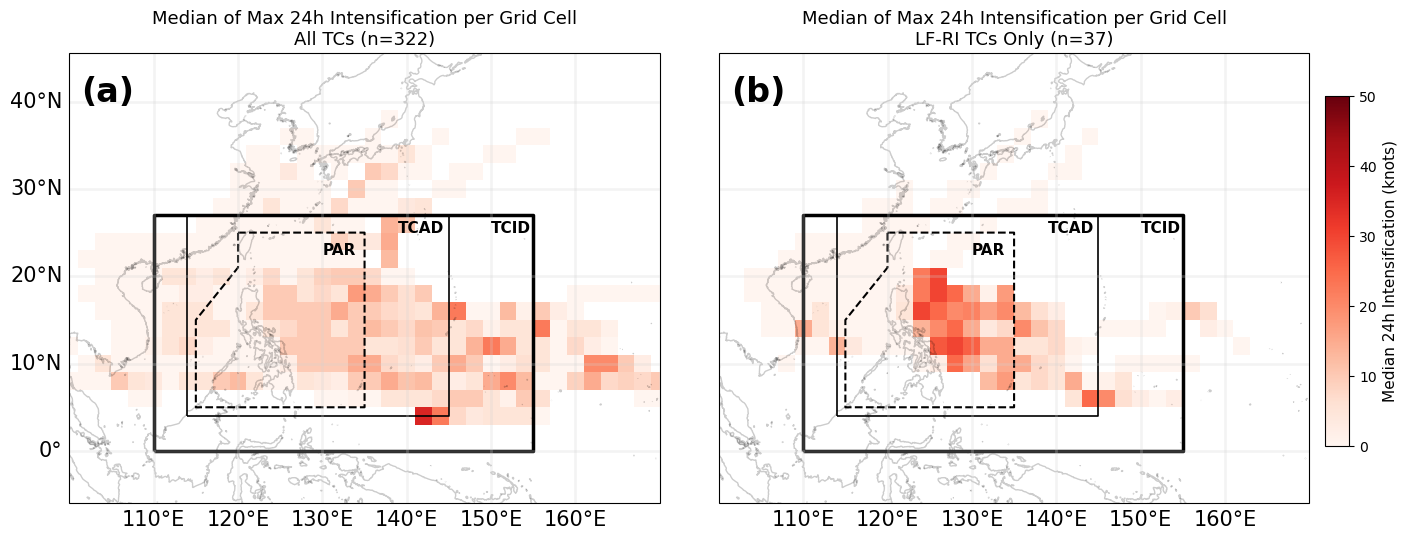

In [39]:
# Reusable function
def compute_grid(df, bin_size, var='max_24h_intensification'):
    df = df[df[var].notna()].copy()
    df['lon'] = df.geometry.x
    df['lat'] = df.geometry.y
    df['lon_bin'] = (df['lon'] / bin_size).round() * bin_size
    df['lat_bin'] = (df['lat'] / bin_size).round() * bin_size
    grid_stats = df.groupby(['lat_bin', 'lon_bin'])[var].median().reset_index()
    pivot = grid_stats.pivot(index='lat_bin', columns='lon_bin', values=var)
    lon_grid = pivot.columns.values
    lat_grid = pivot.index.values
    lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
    return lon_mesh, lat_mesh, pivot.values

# Parameters
bin_size = 2
df_all_map = df_ph_labeled[df_ph_labeled['max_24h_intensification'].notna()].copy()
df_ri_map = df_ph_labeled[(df_ph_labeled['is_RI']) & (df_ph_labeled['max_24h_intensification'].notna())].copy()
n_all = df_all_map['SID'].nunique()
n_ri = df_ri_map['SID'].nunique()

# Compute data
lon1, lat1, Z1 = compute_grid(df_all_map, bin_size)
lon2, lat2, Z2 = compute_grid(df_ri_map, bin_size)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 7), subplot_kw={'projection': ccrs.PlateCarree()})
titles = [
    f"All TCs (n={n_all})",
    f"LF-RI TCs Only (n={n_ri})"
]
datasets = [(lon1, lat1, Z1), (lon2, lat2, Z2)]


panel_labels = ['(a)', '(b)']
for ax, label in zip(axs.flat, panel_labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes, fontsize=24,
            fontweight='bold', va='top', ha='left')
for i, (ax, (lon, lat, Z), title) in enumerate(zip(axs, datasets, titles)):
    mesh = ax.pcolormesh(lon, lat, Z, shading='auto', cmap='Reds', vmin=0, vmax=50)
    ax.set_title(f"Median of Max 24h Intensification per Grid Cell\n{title}", fontsize=13)
    ax.set_extent([100, 170, -5, 40])
    ax.coastlines(resolution='10m', alpha=0.2)
    # ax.add_feature(cfeature.BORDERS, linestyle=':')
    # ax.add_feature(cfeature.LAND, facecolor='lightgray')
    # ax.add_feature(cfeature.OCEAN, facecolor='white')

    # Plot TCID, TCAD, PAR boundaries
    # gdf_tcid.boundary.plot(ax=ax, edgecolor='green', linewidth=1)
    # gdf_tcad.boundary.plot(ax=ax, edgecolor='gold', linewidth=1)
    # gdf_par.boundary.plot(ax=ax, edgecolor='red', linewidth=1)

    # Plot TCID with thick solid green line
    gdf_tcid.boundary.plot(ax=ax, edgecolor='k', linewidth=2.5, linestyle='-')

    # Plot TCAD with thinner golden line
    gdf_tcad.boundary.plot(ax=ax, edgecolor='k', linewidth=1.2, linestyle='-')

    # Plot PAR with dashed red line
    gdf_par.boundary.plot(ax=ax, edgecolor='k', linewidth=1.5, linestyle='--')

    
    # Add labels manually (you can fine-tune the xy position)
    ax.text(150, 25, "TCID", color='k', fontsize=11, weight='bold')
    ax.text(139, 25, "TCAD", color='k', fontsize=11, weight='bold')
    ax.text(130, 22.5, "PAR", color='k', fontsize=11, weight='bold')

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='lightgray', alpha=0.25, linestyle='-')
    gl.top_labels = False
    gl.right_labels = False
    if i == 1:
        gl.left_labels = False

    gl.xlocator = mticker.FixedLocator(np.arange(100, 175, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(0, 45, 10))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'k'}
    gl.ylabel_style = {'size': 15, 'color': 'k'}

# Shared colorbar
cbar_ax = fig.add_axes([0.91, 0.25, 0.015, 0.5])
cbar = plt.colorbar(mesh, cax=cbar_ax)
cbar.set_label('Median 24h Intensification (knots)', fontsize=11)

fig.subplots_adjust(wspace=0.1, bottom=0.1, top=0.88)
plt.show()

fig.savefig('plot/Figure05_tc_intensification_map_with_domains.png', dpi=300, bbox_inches='tight')


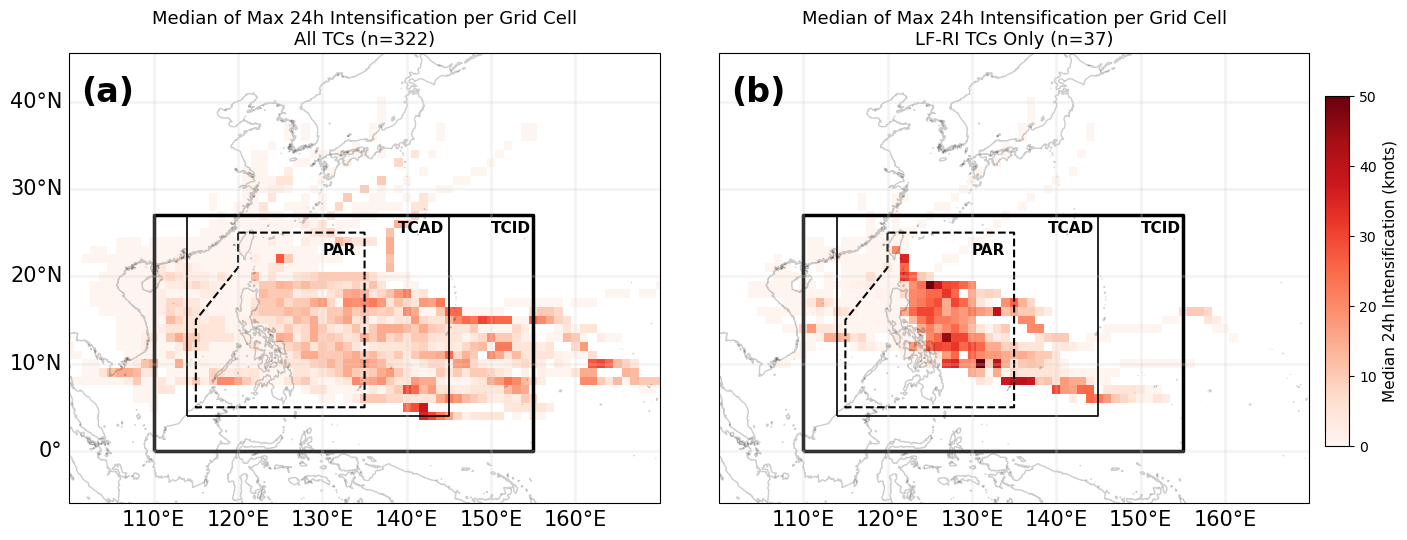

In [40]:
# Reusable function
def compute_grid(df, bin_size, var='max_24h_intensification'):
    df = df[df[var].notna()].copy()
    df['lon'] = df.geometry.x
    df['lat'] = df.geometry.y
    df['lon_bin'] = (df['lon'] / bin_size).round() * bin_size
    df['lat_bin'] = (df['lat'] / bin_size).round() * bin_size
    grid_stats = df.groupby(['lat_bin', 'lon_bin'])[var].median().reset_index()
    pivot = grid_stats.pivot(index='lat_bin', columns='lon_bin', values=var)
    lon_grid = pivot.columns.values
    lat_grid = pivot.index.values
    lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
    return lon_mesh, lat_mesh, pivot.values

# Parameters
bin_size = 1
df_all_map = df_ph_labeled[df_ph_labeled['max_24h_intensification'].notna()].copy()
df_ri_map = df_ph_labeled[(df_ph_labeled['is_RI']) & (df_ph_labeled['max_24h_intensification'].notna())].copy()
n_all = df_all_map['SID'].nunique()
n_ri = df_ri_map['SID'].nunique()

# Compute data
lon1, lat1, Z1 = compute_grid(df_all_map, bin_size)
lon2, lat2, Z2 = compute_grid(df_ri_map, bin_size)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 7), subplot_kw={'projection': ccrs.PlateCarree()})
titles = [
    f"All TCs (n={n_all})",
    f"LF-RI TCs Only (n={n_ri})"
]
datasets = [(lon1, lat1, Z1), (lon2, lat2, Z2)]


panel_labels = ['(a)', '(b)']
for ax, label in zip(axs.flat, panel_labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes, fontsize=24,
            fontweight='bold', va='top', ha='left')
for i, (ax, (lon, lat, Z), title) in enumerate(zip(axs, datasets, titles)):
    mesh = ax.pcolormesh(lon, lat, Z, shading='auto', cmap='Reds', vmin=0, vmax=50)
    ax.set_title(f"Median of Max 24h Intensification per Grid Cell\n{title}", fontsize=13)
    ax.set_extent([100, 170, -5, 40])
    ax.coastlines(resolution='10m', alpha=0.2)
    # ax.add_feature(cfeature.BORDERS, linestyle=':')
    # ax.add_feature(cfeature.LAND, facecolor='lightgray')
    # ax.add_feature(cfeature.OCEAN, facecolor='white')

    # Plot TCID, TCAD, PAR boundaries
    # gdf_tcid.boundary.plot(ax=ax, edgecolor='green', linewidth=1)
    # gdf_tcad.boundary.plot(ax=ax, edgecolor='gold', linewidth=1)
    # gdf_par.boundary.plot(ax=ax, edgecolor='red', linewidth=1)

    # Plot TCID with thick solid green line
    gdf_tcid.boundary.plot(ax=ax, edgecolor='k', linewidth=2.5, linestyle='-')

    # Plot TCAD with thinner golden line
    gdf_tcad.boundary.plot(ax=ax, edgecolor='k', linewidth=1.2, linestyle='-')

    # Plot PAR with dashed red line
    gdf_par.boundary.plot(ax=ax, edgecolor='k', linewidth=1.5, linestyle='--')

    
    # Add labels manually (you can fine-tune the xy position)
    ax.text(150, 25, "TCID", color='k', fontsize=11, weight='bold')
    ax.text(139, 25, "TCAD", color='k', fontsize=11, weight='bold')
    ax.text(130, 22.5, "PAR", color='k', fontsize=11, weight='bold')

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='lightgray', alpha=0.25, linestyle='-')
    gl.top_labels = False
    gl.right_labels = False
    if i == 1:
        gl.left_labels = False

    gl.xlocator = mticker.FixedLocator(np.arange(100, 175, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(0, 45, 10))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'k'}
    gl.ylabel_style = {'size': 15, 'color': 'k'}

# Shared colorbar
cbar_ax = fig.add_axes([0.91, 0.25, 0.015, 0.5])
cbar = plt.colorbar(mesh, cax=cbar_ax)
cbar.set_label('Median 24h Intensification (knots)', fontsize=11)

fig.subplots_adjust(wspace=0.1, bottom=0.1, top=0.88)
plt.show()

fig.savefig('plot/Figure05_tc_intensification_map_with_domains_1x1.png', dpi=300, bbox_inches='tight')
